In [1]:
from torchvision import transforms
from torchvision.datasets import FashionMNIST, CIFAR10, CIFAR100
from models.cleaner import NoiseCleaner
from models.predictor import Predictor

# Instance Independent

In [ ]:
train_dataset = FashionMNIST(root='data', train=True, download=False)
transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
noise_cleaner = NoiseCleaner(train_dataset, noise_type='iin', model_save_path="fmnist/resnet18/model_resnet18_fmnist_fold_{}.pth", folds_num=5, model='resnet18', train_noise_level=0.2, epochs_num=32, transform=transform)

In [6]:
noise_cleaner.clean()

Training fold 1/5...


Testing: 100%|██████████| 125/125 [00:01<00:00, 71.76it/s]


Test Accuracy: 64.75%
Test Precision: 0.66
Test Recall: 0.65
Test F1 Score: 0.65
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_1.pth
Finished training fold 1
Training fold 2/5...


Testing: 100%|██████████| 125/125 [00:01<00:00, 71.34it/s]


Test Accuracy: 61.70%
Test Precision: 0.66
Test Recall: 0.62
Test F1 Score: 0.62
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_2.pth
Finished training fold 2
Training fold 3/5...


Testing: 100%|██████████| 125/125 [00:01<00:00, 71.35it/s]


Test Accuracy: 61.80%
Test Precision: 0.63
Test Recall: 0.62
Test F1 Score: 0.61
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_3.pth
Finished training fold 3
Training fold 4/5...


Testing: 100%|██████████| 125/125 [00:01<00:00, 71.93it/s]


Test Accuracy: 64.85%
Test Precision: 0.65
Test Recall: 0.65
Test F1 Score: 0.65
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_4.pth
Finished training fold 4
Training fold 5/5...


Testing: 100%|██████████| 125/125 [00:01<00:00, 71.80it/s]


Test Accuracy: 58.50%
Test Precision: 0.62
Test Recall: 0.58
Test F1 Score: 0.57
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_5.pth
Finished training fold 5


Evaluating Noisy Samples for fold 5: 100%|██████████| 25/25 [00:51<00:00,  2.07s/it]


Predicted noise indices: [31391, 38198, 50882, 30217, 48283, 12407, 14964, 26725, 9661, 39355, 37127, 16849, 27681, 50029, 57399, 20285, 7836, 17999, 12423, 6347, 4, 15593, 52943, 48482, 16883, 52065, 58560, 47127, 14951, 8972, 24032, 54970, 40459, 2440, 19375, 9433, 38770, 37147, 58353, 29078, 41472, 4244, 19497, 11265, 23491, 36756, 14107, 47428, 32066, 38052, 51834, 8893, 19334, 54294, 50730, 8473, 41904, 13132, 22917, 56457, 24975, 21095, 42389, 48792, 28306, 31930, 55536, 8504, 803, 25636, 27343, 33254, 3649, 51091, 27727, 22475, 20986, 39283, 17363, 5345, 31677, 22527, 50712, 19077, 9536, 40423, 18446, 3272, 54719, 47854, 48962, 54742, 32633, 8501, 28321, 59452, 39786, 10946, 47395, 14009, 23805, 45160, 47501, 34101, 25055, 34146, 12163, 9588, 15603, 34106, 56099, 55372, 33557, 16266, 6972, 47435, 46047, 22376, 35263, 26742, 8994, 39615, 47719, 6418, 5394, 24200, 26741, 8479, 21858, 30602, 58181, 56650, 1562, 35671, 34577, 39750, 1563, 29045, 12933, 37135, 50282, 18352, 31641, 59

Testing: 100%|██████████| 125/125 [00:01<00:00, 72.55it/s]


Test Accuracy: 62.70%
Test Precision: 0.64
Test Recall: 0.63
Test F1 Score: 0.63
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_1.pth
Finished training fold 1
Training fold 2/5...


Testing: 100%|██████████| 125/125 [00:01<00:00, 74.07it/s]


Test Accuracy: 64.40%
Test Precision: 0.65
Test Recall: 0.64
Test F1 Score: 0.64
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_2.pth
Finished training fold 2
Training fold 3/5...


Testing: 100%|██████████| 125/125 [00:01<00:00, 74.24it/s]


Test Accuracy: 60.30%
Test Precision: 0.64
Test Recall: 0.60
Test F1 Score: 0.57
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_3.pth
Finished training fold 3
Training fold 4/5...


Testing: 100%|██████████| 125/125 [00:01<00:00, 69.94it/s]


Test Accuracy: 63.80%
Test Precision: 0.65
Test Recall: 0.64
Test F1 Score: 0.64
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_4.pth
Finished training fold 4
Training fold 5/5...


Testing: 100%|██████████| 125/125 [00:01<00:00, 72.34it/s]


Test Accuracy: 62.65%
Test Precision: 0.63
Test Recall: 0.63
Test F1 Score: 0.62
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_5.pth
Finished training fold 5


Evaluating Noisy Samples for fold 5: 100%|██████████| 25/25 [00:54<00:00,  2.18s/it]


Predicted noise indices: [8694, 17286, 30758, 53874, 3912, 54009, 57126, 22896, 11127, 42323, 45725, 10277, 25419, 3578, 11499, 56148, 21963, 34697, 1166, 43300, 10388, 50298, 438, 41193, 51661, 31441, 34437, 43836, 25062, 54055, 39050, 44046, 9813, 37281, 21333, 51521, 2020, 10151, 5935, 58343, 51228, 4831, 8541, 43177, 16134, 24960, 2917, 32415, 21023, 33912, 2264, 21930, 29875, 50351, 47756, 55254, 37278, 54712, 9801, 10037, 10071, 58358, 30248, 16629, 2467, 48600, 657, 41052, 50681, 12536, 40015, 14045, 55471, 13310, 14073, 19753, 6029, 28501, 45498, 29494, 11472, 2137, 39538, 32904, 19386, 33081, 23455, 43450, 50655, 15049, 41363, 6815, 40468, 27555, 11, 37638, 15130, 53273, 59607, 45677, 3930, 6551, 11380, 28532, 13556, 3351, 52821, 56720, 45166, 8538, 18983, 57934, 42803, 13889, 13153, 3452, 4520, 44567, 41504, 18166, 6346, 23264, 48103, 34859, 13053, 11627, 34564, 8439, 49229, 17588, 9523, 26827, 23917, 14889, 47459, 30923, 28578, 26446, 4356, 15738, 37076, 26412, 40190, 49995,

Testing: 100%|██████████| 125/125 [00:01<00:00, 72.04it/s]


Test Accuracy: 63.70%
Test Precision: 0.64
Test Recall: 0.64
Test F1 Score: 0.63
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_1.pth
Finished training fold 1
Training fold 2/5...


Testing: 100%|██████████| 125/125 [00:01<00:00, 69.83it/s]


Test Accuracy: 63.15%
Test Precision: 0.66
Test Recall: 0.63
Test F1 Score: 0.62
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_2.pth
Finished training fold 2
Training fold 3/5...


Testing: 100%|██████████| 125/125 [00:01<00:00, 73.99it/s]


Test Accuracy: 62.60%
Test Precision: 0.66
Test Recall: 0.63
Test F1 Score: 0.62
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_3.pth
Finished training fold 3
Training fold 4/5...


Testing: 100%|██████████| 125/125 [00:01<00:00, 71.84it/s]


Test Accuracy: 58.90%
Test Precision: 0.61
Test Recall: 0.59
Test F1 Score: 0.57
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_4.pth
Finished training fold 4
Training fold 5/5...


Testing: 100%|██████████| 125/125 [00:01<00:00, 72.40it/s]


Test Accuracy: 57.95%
Test Precision: 0.63
Test Recall: 0.58
Test F1 Score: 0.58
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_5.pth
Finished training fold 5


Evaluating Noisy Samples for fold 5: 100%|██████████| 25/25 [00:54<00:00,  2.19s/it]


Predicted noise indices: [58273, 29487, 19907, 30551, 25798, 58926, 2047, 35225, 10031, 10038, 31196, 56928, 41331, 11558, 22975, 58170, 16472, 47193, 9525, 42724, 18396, 5210, 5623, 4685, 51094, 22840, 5980, 85, 33504, 56693, 16793, 35075, 18580, 59906, 59599, 11754, 28285, 26117, 18791, 56599, 4450, 12459, 11631, 3724, 3268, 11629, 47256, 26507, 4717, 16747, 42041, 19205, 12434, 54146, 28999, 49400, 4751, 52144, 21299, 27372, 41729, 2727, 234, 6263, 57357, 41525, 12880, 41006, 45752, 14907, 7202, 40548, 50391, 24428, 29859, 6586, 53113, 55853, 44902, 39128, 44272, 20362, 49109, 38919, 41254, 25214, 59339, 5725, 15705, 22066, 24305, 8979, 41188, 38718, 48271, 50328, 39176, 57734, 17865, 20523, 50418, 39549, 30956, 58069, 16802, 18206, 24681, 27968, 26158, 46044, 47460, 48035, 39378, 9970, 28745, 11931, 18336, 38329, 38856, 38624, 45381, 25572, 7713, 36944, 5101, 54687, 39259, 54365, 29646, 24732, 13559, 6005, 14420, 54538, 451, 35811, 38266, 14466, 20818, 39195, 45830, 4100, 49941, 22

Testing: 100%|██████████| 125/125 [00:01<00:00, 73.17it/s]


Test Accuracy: 63.45%
Test Precision: 0.65
Test Recall: 0.63
Test F1 Score: 0.63
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_1.pth
Finished training fold 1
Training fold 2/5...


Testing: 100%|██████████| 125/125 [00:01<00:00, 71.44it/s]


Test Accuracy: 64.55%
Test Precision: 0.65
Test Recall: 0.65
Test F1 Score: 0.64
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_2.pth
Finished training fold 2
Training fold 3/5...


Testing: 100%|██████████| 125/125 [00:01<00:00, 78.52it/s]


Test Accuracy: 65.95%
Test Precision: 0.67
Test Recall: 0.66
Test F1 Score: 0.66
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_3.pth
Finished training fold 3
Training fold 4/5...


Testing: 100%|██████████| 125/125 [00:01<00:00, 74.88it/s]


Test Accuracy: 62.65%
Test Precision: 0.64
Test Recall: 0.63
Test F1 Score: 0.62
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_4.pth
Finished training fold 4
Training fold 5/5...


Testing: 100%|██████████| 125/125 [00:01<00:00, 74.95it/s]


Test Accuracy: 59.15%
Test Precision: 0.63
Test Recall: 0.59
Test F1 Score: 0.58
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_5.pth
Finished training fold 5


Evaluating Noisy Samples for fold 5: 100%|██████████| 25/25 [00:55<00:00,  2.22s/it]


Predicted noise indices: [9257, 4646, 32228, 48065, 34956, 4536, 45300, 8272, 38002, 39155, 27414, 25685, 11371, 31236, 34623, 3499, 50250, 29144, 32521, 51404, 11351, 40170, 48326, 20319, 40702, 26379, 27873, 29605, 14507, 33519, 42518, 52566, 8743, 33910, 440, 1359, 47003, 20703, 29607, 16285, 19669, 36292, 27272, 18096, 57526, 39846, 39347, 19455, 17916, 46849, 5376, 16738, 22217, 46336, 11152, 36415, 22196, 41608, 18409, 37123, 25823, 14193, 23946, 39879, 40699, 21872, 16352, 45886, 28789, 30300, 30067, 22869, 7670, 30203, 14735, 24243, 18208, 35568, 55840, 53354, 39618, 18038, 24776, 13346, 29802, 57345, 7529, 794, 39374, 32267, 3065, 25793, 54346, 54985, 21859, 52025, 38206, 1439, 56997, 3251, 50237, 32089, 53216, 34018, 41911, 29317, 46475, 38422, 59592, 16310, 56350, 56831, 16496, 50718, 30885, 16447, 6922, 33295, 36078, 21151, 40723, 27387, 6641, 42000, 38493, 51358, 3205, 50137, 14633, 30086, 16165, 36897, 37403, 16533, 34870, 4329, 23896, 30382, 22187, 28183, 40335, 14166, 2

Testing: 100%|██████████| 125/125 [00:01<00:00, 78.54it/s]


Test Accuracy: 60.70%
Test Precision: 0.63
Test Recall: 0.61
Test F1 Score: 0.60
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_1.pth
Finished training fold 1
Training fold 2/5...


Testing: 100%|██████████| 125/125 [00:01<00:00, 71.28it/s]


Test Accuracy: 63.40%
Test Precision: 0.64
Test Recall: 0.63
Test F1 Score: 0.63
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_2.pth
Finished training fold 2
Training fold 3/5...


Testing: 100%|██████████| 125/125 [00:01<00:00, 76.50it/s]


Test Accuracy: 61.00%
Test Precision: 0.64
Test Recall: 0.61
Test F1 Score: 0.60
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_3.pth
Finished training fold 3
Training fold 4/5...


Testing: 100%|██████████| 125/125 [00:01<00:00, 73.63it/s]


Test Accuracy: 63.10%
Test Precision: 0.64
Test Recall: 0.63
Test F1 Score: 0.63
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_4.pth
Finished training fold 4
Training fold 5/5...


Testing: 100%|██████████| 125/125 [00:01<00:00, 70.22it/s]


Test Accuracy: 64.30%
Test Precision: 0.65
Test Recall: 0.64
Test F1 Score: 0.64
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_5.pth
Finished training fold 5


Evaluating Noisy Samples for fold 5: 100%|██████████| 25/25 [00:56<00:00,  2.27s/it]


Predicted noise indices: [27127, 26289, 12561, 21823, 24427, 25464, 10222, 38934, 35323, 2461, 26555, 30087, 29301, 13171, 15493, 45151, 58014, 2200, 35199, 42133, 17772, 9964, 446, 36509, 7856, 1813, 25242, 26270, 1849, 48665, 32479, 44100, 11279, 39029, 45186, 6317, 18394, 32921, 54869, 39099, 57109, 19225, 14292, 53045, 41266, 52389, 5972, 58220, 15034, 28902, 2217, 54370, 49159, 23762, 16014, 48632, 18064, 18635, 4114, 21684, 56138, 39261, 36395, 57531, 5577, 39256, 13237, 21133, 18908, 58245, 1524, 40115, 5448, 8804, 10680, 34620, 21966, 51831, 10634, 18982, 39188, 778, 35854, 40581, 42913, 57394, 36982, 39121, 33972, 6152, 25338, 28273, 32981, 34592, 41750, 5696, 41196, 2869, 1678, 6554, 57867, 27306, 12720, 49201, 50108, 29932, 23525, 36439, 47399, 3071, 54498, 6766, 22161, 30418, 34959, 44564, 7866, 57918, 28583, 56847, 49281, 58067, 11953, 3346, 43404, 23574, 3149, 23544, 13854, 17276, 7187, 5415, 49317, 45836, 27122, 23328, 47086, 24226, 51550, 23776, 6701, 7086, 37952, 54351

In [18]:
clean_train_dataset = noise_cleaner.clean_dataset
test_dataset = FashionMNIST(root='data', train=False, download=False)
predictor = Predictor(train_dataset=clean_train_dataset, test_dataset=test_dataset, transform=transform, num_classes=10, model_type='resnet18', batch_size=400, num_epochs=50)

In [ ]:
predictor.train(10)

In [24]:
predictor.evaluate()

Evaluating: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]

Test Accuracy: 92.33%


0.9233

# Instance Dependent

In [4]:
train_dataset = FashionMNIST(root='data', train=True, download=False)
transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
noise_cleaner = NoiseCleaner(train_dataset, noise_type='idn', model_save_path="fmnist/resnet18/model_resnet18_fmnist_fold_{}.pth", folds_num=10, model='resnet18', train_noise_level=0.2, epochs_num=40, transform=transform, train_pairs=10000, val_pairs=1000)

Seed: 88
noise count: 12175 out of 60000 data


Training fold 1/10...


Extracting Embeddings: 100%|██████████| 125/125 [00:02<00:00, 60.46it/s]


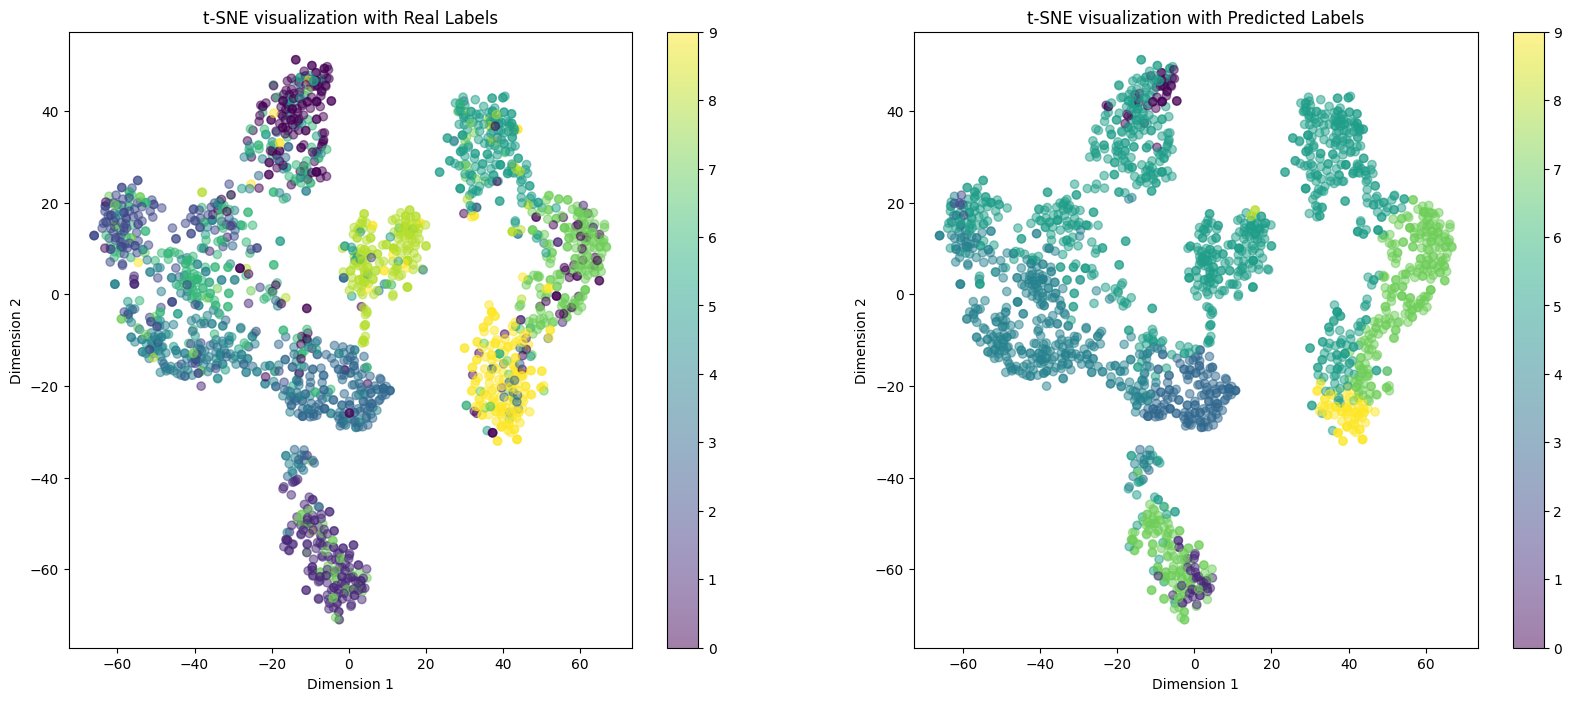

value counts for predicted:
[[  0  39]
 [  1  40]
 [  2   6]
 [  3 152]
 [  4 394]
 [  5 926]
 [  7 372]
 [  8   4]
 [  9  67]]
value counts for real:
[[  0 211]
 [  1 168]
 [  2 149]
 [  3 201]
 [  4 237]
 [  5 239]
 [  6 187]
 [  7 249]
 [  8 179]
 [  9 180]]


Testing: 100%|██████████| 125/125 [00:01<00:00, 69.57it/s]
/home/aref/.conda/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 39.35%
Test Precision: 0.58
Test Recall: 0.39
Test F1 Score: 0.34
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_1.pth
Finished training fold 1
Training fold 2/10...


Epoch 1/50:   2%|▏         | 1/50 [00:37<30:42, 37.60s/it, loss=11.5]


KeyboardInterrupt: 

In [5]:
noise_cleaner.clean()